# **Imports ve Sabitler**

In [1]:
import os
import numpy as np
from spectral import *
import spectral.io.envi as envi
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense,Dropout, BatchNormalization,Reshape,LSTM
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.ndimage import uniform_filter, gaussian_filter,median_filter
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.cluster import KMeans


In [2]:
spectral.settings.envi_support_nonlowercase_params = True

# Define the base directory
data_folder = "c:/proje/hasta"
patch_size=3

# Sınıf isimleri
CLASS_NAMES = {
    1: "Normal Doku",
    2: "Tümör Dokusu",
    3: "Hipervaskülarize Doku",
    4: "Arka plan"
}

tumorluler=["008-01", "008-02", "012-01", "012-02", "015-01", "020-01", "021-01", "021-02", "022-03", "025-02", "028-05", "029-04", 
            "034-02", "034-03", "035-02", "036-02", "037-03", "037-04", "038-01", "039-01", "039-02", "040-01", "040-02", "041-01", 
            "041-02", "042-02", "042-03", "043-01", "043-02"]

haricler=["012-01", "012-02","043-01", "043-02","022-03","004-02","010-03","038-01","029-04"]

# Sınıflara atanacak renkler
colors = ["green", "red", "blue", "black"]

In [3]:
# TensorFlow sürümünü kontrol et nvidia-smi ile consolda takip
print("TensorFlow version:", tf.__version__)

# gpu zorlama
# with tf.device('/GPU:0'):
#   kodlar....

# GPU'nun kullanılabilirliğini kontrol et
gpu_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if gpu_devices:
    print("GPU available:", gpu_devices)
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
    try:
        # Dinamik bellek tahsisi ayarla
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("Dinamik Bellek Kullanımı Ayarlandı!")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not available")


TensorFlow version: 2.10.1
Num GPUs Available:  1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dinamik Bellek Kullanımı Ayarlandı!


# **Image İşleme Fonksiyonları**

## Filtreler

In [4]:
def noise(data, filter_size=5):
    # Uzaysal filtreleme: her bant için uygulanır    
    return uniform_filter(data, size=filter_size)
    """
    filtered_data = np.empty_like(data)
    for i in range(data.shape[2]):  # Bantlar boyunca dön
        filtered_data[:, :, i] = uniform_filter(data[:, :, i], size=filter_size)
    return filtered_data
    """

# Spektral Düzeltme (Gaussian Smoothing)
def gauss(data, sigma=1):    
    return gaussian_filter(data, sigma=(0, 0, sigma))

# Normalize Etme
def normalize(data):    
    """filtered_data = np.empty_like(data)
    for i in range(data.shape[2]):  # Bantlar boyunca dön
        min_val = np.min(data[:, :, i])
        max_val = np.max(data[:, :, i])
        filtered_data[:, :, i] = (data[:, :, i] - min_val) / (data[:, :, i] - min_val+ 1e-9)    
    return filtered_data
    """
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val+ 1e-9)       



## Image dosya ve Bant düşürme işlemleri

In [5]:
# Veri ve etiketlerin işlenmesi
def extract_patches_and_labels(data, label_map, patch_size=3,full_image=False): #full_image true ise 0 larıda dahil eder
    half_size = patch_size // 2
    patches = []
    labels = []

    # Etiketlerin geçerli olduğu bölgeyi tarar
    for i in range(half_size, data.shape[0] - half_size):
        for j in range(half_size, data.shape[1] - half_size):
            if (full_image)or(label_map[i, j] > 0):  # Sadece etiketli alanları kullan
                patch = data[i - half_size : i + half_size + 1,
                j - half_size : j + half_size + 1, :]
                patches.append(patch)
                labels.append(label_map[i, j])

    print(f"min={np.min(labels)}")

    return np.array(patches), np.array(labels)

def read_hdr_files(image_path, label_path):
    """
    raw.hdr ve gtMap.hdr dosyalarını okur.
    Args:
        image_path (str): raw.hdr dosya yolu.
        label_path (str): gtMap.hdr dosya yolu.
    Returns:
        tuple: (image_data, label_map)
    """
    image_data = open_image(image_path).load()  # raw.hdr yükleme kodu
    label_map = open_image(label_path).load()  # gtMap.hdr yükleme kodu
    return image_data, label_map

def rgb(data,r=369,g=136,b=53,bolen=1): #   r=369,g=136,b=53 644 bantlık karsılık gelen rgb bantları bolen 5 verildigi zaman 128 e karsılık gelenler secilir
    #Image dan belirtilen batlarda RGB imahe olustur
    return get_rgb(data, (r // bolen, g // bolen, b //bolen))    



# **Modeller**

## **1.Model 3D CNN**

In [ ]:
def create_3d_cnn(num_classes,patch_size,bandcount):
    print(f"Model {1} num_classes {num_classes} patch_size {patch_size} ,bandcount {bandcount}")

    model = Sequential()
    # İlk konvolüsyon bloğu
    model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(patch_size, patch_size,bandcount , 1) , activation='relu', padding='same'))    
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 1, 2), padding='same'))

    # İkinci konvolüsyon bloğu
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 1, 2), padding='same'))

    # Üçüncü konvolüsyon bloğu
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 1, 2), padding='same'))
    
    # Tam bağlantılı katmanlar
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Çıkış katmanı
    model.add(Dense(num_classes, activation='softmax'))

    return model

## **2.Model 3D Hybrid CNN+LSTM**

In [ ]:
def create_hybrid_cnn_rnn(num_classes,patch_size,bandcount):
    print(f"Model {2} num_classes {num_classes} patch_size {patch_size} ,bandcount {bandcount}")

    model = Sequential()

    # İlk konvolüsyon bloğu (3D Convolution)

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',
                     input_shape=(patch_size, patch_size, bandcount, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 5), padding='same'))

    # İkinci konvolüsyon bloğu (3D Convolution)
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 5), padding='same'))

    # Üçüncü konvolüsyon bloğu (3D Convolution)
    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 5), padding='same'))

    # 3D CNN Çıkışının Şekillendirilmesi (RNN için yeniden şekillendirme)
    model.add(Reshape((-1, 256)))  # RNN uyumu için spektral boyutun zaman serisine dönüştürülmesi

    # RNN Katmanları (LSTM)
    model.add(LSTM(128, return_sequences=False, activation='relu'))  # Tek bir çıktı için return_sequences=False

    # Tam bağlantılı katmanlar
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Çıkış katmanı
    model.add(Dense(num_classes, activation='softmax'))

    return model


## **3.Model 3D CNN v2**

In [ ]:
def create_3d_cnn_v2(num_classes,patch_size,bandcount):
    print(f"Model {3} num_classes {num_classes} patch_size {patch_size} ,bandcount {bandcount}")

    model = Sequential()

    # 3D CNN Katmanları
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(patch_size, patch_size, bandcount, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    # 1D CNN Katmanları
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Çıkış katmanı
    model.add(Dense(num_classes, activation='softmax'))

    return model

# **Toplu İşlemler**


## Image(lar) yükleme

In [9]:
# Görüntüyü parlaklaştırma fonksiyonu
def adjust_auto_brightness(image,target_mean=0.35):
    """
    Görüntünün parlaklığını ayarlar.
    image: Girdi görüntüsü (örneğin RGB veya gri tonlamalı).
    factor: Parlaklık çarpanı (1.0 hiçbir değişiklik yapmaz, >1 parlaklaştırır, <1 karartır).
    """

    scale_factor = target_mean / np.mean(image)
    
    return np.clip(image * scale_factor, 0, 1)  # Piksel değerlerini [0, 1] arasında sınırlandır


def load_images(hasta_dataset_path=data_folder,
                rawfile="calibrated_raw",
                patch_size=3,
                usedirectfile=True,
                showimage=False,
                fullclasses=False,
                filters=[],
                filtreuygula=True,
                hasta_sayisi=100
                ):
     # Dataset klasöründeki tüm verileri yükleme
    all_patches = []
    all_labels = []
    folder_count=0

    islenenfiltreler=''

    

    for root, dirs, files in os.walk(hasta_dataset_path):            
        # Klasörleri alfabetik sıraya göre sıralıyoruz
        dirs.sort()

        if  rawfile+'.hdr' in files and "gtMap.hdr" in files:
            folder_count += 1  # Klasör sayısını artır
            if folder_count > hasta_sayisi:  # hasta_sayisi klasör işlendiyse döngüden çık
                break
            
            print(f"{folder_count}.Hasta dosyası:{root} {rawfile}")

            
            data, label_map = read_hdr_files(os.path.join(root, rawfile+'.hdr'), os.path.join(root, 'gtMap.hdr'))
            #data=adjust_auto_brightness(data)
            
            print(f"Image data shape:{data.shape} Label_map shape {label_map.shape}")

            if (showimage):
              pngfolder=f'png/{rawfile}'
                
              if not os.path.exists(pngfolder):
                  os.makedirs(pngfolder)
                  
              masked_label_map = np.ma.masked_equal(label_map, 0)  
              # ListedColormap ile özel renk haritası oluşturma
              cmap = ListedColormap(colors)
              bounds = [1, 2, 3, 4, 5]  # Sınıf sınırları
              norm = BoundaryNorm(bounds, cmap.N)  

              parlakimage=adjust_auto_brightness(data)              
              rgbimage=rgb(parlakimage,bolen=5)               
                
              plt.figure(figsize=(12, 5))
              plt.suptitle(f"Hasta: {hasta} - Görüntü ve Etiket Haritası", fontsize=16)
              plt.subplot(1, 2, 1)
              plt.title(f"Orijinal Görüntü (RGB)")
              plt.imshow(rgbimage, cmap='gray')  # İlk bandı görselleştir              
        
              plt.subplot(1, 2, 2)
              plt.title("Gerçek Etiket Haritası")
              plt.imshow(parlakimage[:, :, 50], cmap='gray')  # İlk bandı görselleştir
              plt.imshow(masked_label_map, cmap=cmap, norm=norm)  # Gerçek etiketleri çiz , alpha=0.8              
                
              pngfilename=f'{pngfolder}/{hasta}.png'  
              plt.savefig(pngfilename, dpi=100, bbox_inches='tight')  
                
              plt.show()  
            

            islenenfiltreler='';
            
            for filtre in filters:
                print(f"{filtre.__name__} işleniyor")
                islenenfiltreler+=f'_{filtre.__name__}'
                if (filtreuygula==True):
                    data=filtre(data)    
    
            # Etiketli görüntüdeki her değeri sayalım
            unique_values, counts = np.unique(label_map, return_counts=True)
    
            # Sonuçları yazdıralım
            for value, count in zip(unique_values, counts):
                print(f"Class: {value}, Count: {count}")        
    
                
            if (showimage):
              pngfolder=f'png/{rawfile}'
                
              if not os.path.exists(pngfolder):
                  os.makedirs(pngfolder)
                  
              masked_label_map = np.ma.masked_equal(label_map, 0)  
              # ListedColormap ile özel renk haritası oluşturma
              cmap = ListedColormap(colors)
              bounds = [1, 2, 3, 4, 5]  # Sınıf sınırları
              norm = BoundaryNorm(bounds, cmap.N)  
              
              parlakimage=adjust_auto_brightness(data)              
              rgbimage=rgb(parlakimage,bolen=5)
                
              plt.figure(figsize=(12, 5))
                
              plt.suptitle(f"Hasta: {hasta} {islenenfiltreler} - Görüntü ve Etiket Haritası ", fontsize=16)
                
              plt.subplot(1, 2, 1)
              plt.title(f"Orijinal Görüntü (RGB)")
              plt.imshow(rgbimage, cmap='gray')  # İlk bandı görselleştir              
        
              plt.subplot(1, 2, 2)
              plt.title("Gerçek Etiket Haritası")
              plt.imshow(parlakimage[:, :, 50], cmap='gray')  # İlk bandı görselleştir
              plt.imshow(masked_label_map, cmap=cmap, norm=norm)  # Gerçek etiketleri çiz , alpha=0.8              
                
              pngfilename=f'{pngfolder}/{hasta}{islenenfiltreler}.png'  
              plt.savefig(pngfilename, dpi=100, bbox_inches='tight')  
                
              plt.show()  
              

            # Yamaları ve etiketleri çıkar
            patches, labels = extract_patches_and_labels(data, label_map, patch_size=patch_size,full_image=fullclasses)
            all_patches.append(patches)
            all_labels.append(labels)        

    return all_patches, all_labels, islenenfiltreler, data,label_map
        
        

## Çıktı/Grafik kayıt

In [10]:

def plot_history(history,pngfilename=''):
  #Egitim sırasındaki epoch dogruluk degerlerini grafige doker  
  print(history.history.keys())
  epoches = np.arange(1,len(history.history.get('loss'))+1)
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,7))
  #fig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))
  ax1.plot(epoches, history.history.get('loss'), 'b',label='Kayıp')
  ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Doğrulama kaybı')
  ax1.set_title('Eğitim ve doğrulama kaybı')
  ax1.legend()
  ax2.plot(epoches, history.history.get('accuracy'), 'b',label='Doğruluk')
  ax2.plot(epoches, history.history.get('val_accuracy'),'bo', label='Doğrulama verisi doğruluğu')
  ax2.set_title('Eğitim ve doğrulama verisi doğruluğu')
  ax2.legend()

  if (pngfilename!=''):
      plt.savefig(pngfilename+'.png', dpi=100, bbox_inches='tight')
      print(f"Kayıt Edildi {pngfilename+'.png'}")

  plt.show()


def save_classification_report_as_image(y_true, y_pred, output_path=''):
    # Classification Report

    report = classification_report(y_true, y_pred)

    # Grafik oluştur
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.text(0.1, 0.5, report, fontsize=14, ha='left', va='center',fontname='monospace')

    # Grafiğin eksenlerini gizle
    ax.axis('off')

    # PNG dosyasına kaydet
    plt.savefig(output_path+'.png', format='png', bbox_inches='tight')
    plt.close()

    print(f"Classification report saved to {output_path}.png")

    return report

def save_modelsummary_report_as_image(model, output_path=''):
    from io import StringIO
    # Model özeti
    summary_str = []
    model.summary(print_fn=lambda x: summary_str.append(x))
    summary_str = "\n".join(summary_str)

    # Grafik oluştur
    # Görselde kullanmak için StringIO
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.text(0.1, 0.5, summary_str, fontsize=10, ha='left', va='center', fontfamily='monospace')
    ax.axis('off')  # Eksenleri kaldır

    # PNG dosyasına kaydet
    plt.savefig(output_path+'.png', format='png', bbox_inches='tight')
    plt.close()

    print(f"Summary report saved to {output_path}.png")
    

def plot_matrix(model, all_labels, X_test, y_test,pngfilename=''):
    y = np.concatenate(all_labels, axis=0)

    # Giriş boyutunu modelden al
    girdi_boyutu = model.input_shape[1:]
    output_shape = model.layers[-1].compute_output_shape(input_shape=(None, *girdi_boyutu))[1]

    print(f"Model {output_shape} sınıf için çıktı veriyor.")

    # Benzersiz etiketleri belirle
    uniq_label = np.array([1., 2., 3., 4.])
    
    # Tahminler ve sınıflandırma raporu
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification Report
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_true_classes, y_pred_classes))
    if (pngfilename!=''):
        save_classification_report_as_image(y_true_classes, y_pred_classes,output_path=pngfilename.replace('matrix','siniflandirma'))


    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=uniq_label, yticklabels=uniq_label)
    plt.title("Karışıklık Matrisi")
    plt.xlabel("Tahmini Etiketler")
    plt.ylabel("Doğru Etiketler")


    if (pngfilename!=''):
      plt.savefig(pngfilename+'.png', dpi=100, bbox_inches='tight')
      print(f"Kayıt Edildi {pngfilename+'.png'}")    
       
    plt.show()    


## Eğitim Fonksiyonları

In [11]:
import gc
from tensorflow.keras import backend as K

def veri_birlestir(all_patches, all_labels):
    # Verileri birleştir
    
    X = np.concatenate(all_patches, axis=0)
    y = np.concatenate(all_labels, axis=0)

    # Etiketleri sıfırdan başlayacak şekilde yeniden düzenle
    label_map= {1.0: 1,2.0:2, 3.0: 3, 4.0: 4}

    y = np.array([label_map[int(label_item)] for label in y for label_item in label.flatten()])
    #y = np.array([label_map[int(label)] for label in y])
    print("yy:", y.shape)
    # CNN ile eğitim için veriyi yeniden şekillendirme
    X = X[..., np.newaxis]  # 3D CNN için kanal boyutunu ekle
    
    print("y cat:",np.min(y),np.max(y))
    
    y = to_categorical(y)  # One-hot encoding

    print("y cat:", y)
    print("y cat:", y.shape)
    print("Image shape:", X.shape)

    return X,y

# Fold sonrası bellek temizliği
K.clear_session()
gc.collect()

def train_model_images(modelno,
                       all_patches=[], 
                       all_labels=[],
                       rawfile="calibrated_raw",
                       patch_size=3,
                       epoch=5,
                       batch_size=32,
                       save=False,                       
                       usedirectfile=True,
                       num_classes=4,
                       islenenfiltreler='',
                       all_testpatches=[], 
                       all_testlabels=[]):

    if len(all_testpatches)>0:
        print("Test ayrı hastalar")
        X_test,y_test=veri_birlestir(all_testpatches, all_testlabels)
        X,y=veri_birlestir(all_patches, all_labels)
        X_train=X
        y_train=y
    else:
        print("Test %80/%20")
        X,y=veri_birlestir(all_patches, all_labels)

        # Veriyi eğitim ve test kümelerine ayırma
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42) #stratify=reduced_labels, sınıflararasında oranlar korunarak bolme yapar
    
        
    
        # modeli derleme
        # num_classes = y.shape[1] # Sınıf sayısı

    print(f"X_train shape: {X_train.shape} X_test shape: {X_test.shape} y_train shape: {y_train.shape} y_test shape: {y_test.shape} ")
    
    print(f"X band {X.shape[3]}")        
    

    if modelno==1:
      create_model = create_3d_cnn
    elif modelno==2:
      create_model = create_hybrid_cnn_rnn
    elif modelno==3:
      create_model = create_3d_cnn_v2
    elif modelno==4:
      create_model = create_3d_cnn_v3

    model = create_model(num_classes,patch_size,X.shape[3])

    # Modeli derleme
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Modelin özetini yazdırma
    model.summary()
    

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # min_delta=0.001, 

    # Modeli eğitme
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=batch_size,callbacks=[early_stopping]) #, callbacks=[early_stopping]

    filename = data_folder+f"/../model/model{modelno}"

    if not os.path.exists(filename):
        os.makedirs(filename)
        print(f"{filename} klasörü oluşturuldu.")

    filename = f"{filename}/model{modelno}_3dcnn_{rawfile}{islenenfiltreler}_h{hasta_sayisi}_p{patch_size}_ep{epoch}_bat{batch_size}"

    if(save):        
        model.save(filename+'.h5', save_format='h5')
        
    # Modelin test doğruluğunu yazdırma
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    if usedirectfile==True:
      print(f"Test Accuracy: {test_accuracy:.2f} Test Loss: {test_loss:.2f}")
    else:
      if (pca>0):
          print(f"PCA {pca} Test Accuracy: {test_accuracy:.2f}")
      else:
          print(f"Band {start_band}_{start_band+band_step} Test Accuracy: {test_accuracy:.2f}")

    

    save_modelsummary_report_as_image(model, output_path=filename+'_summary')

    print("")
    print("---------------------------------")
    print("")
    
    plot_history(history,pngfilename=filename+'_history')
    plot_matrix(model,all_labels,X_test,y_test,pngfilename=filename+'_matrix')
    # Fold sonrası bellek temizliği
    K.clear_session()
    gc.collect()
    return model,history,X_test,y_test


## İşleme Adımı

### Tek model eğitimi

In [ ]:
#Tek bir Image tipini eğitme

hasta_sayisi=60
rawfile="calibrated_pca_5"
patch_size=3
epoch=20
batch_size=8
modelno=1
num_classes=5
filters=[noise,normalize]

all_patches, all_labels, islenenfiltreler,img,gtmap=load_images(hasta_dataset_path=data_folder,
                                                      rawfile=rawfile,
                                                      patch_size=patch_size,
                                                      usedirectfile=True,
                                                      showimage=False,
                                                      fullclasses=False,
                                                      filters=filters,
                                                      hasta_sayisi=hasta_sayisi
                                                     )




model,history,xtest,ytest=train_model_images(modelno=modelno,
                                             all_patches=all_patches, 
                                             all_labels=all_labels,
                                             rawfile=rawfile,
                                             patch_size=patch_size,
                                             epoch=epoch,
                                             batch_size=batch_size,
                                             save=True,
                                             usedirectfile=True,
                                             num_classes=num_classes,
                                             islenenfiltreler=islenenfiltreler
                                            )



### Toplu model eğitimi Model>Image>Batch

In [ ]:
#tüm image tiplerini , tüm modellerle sırası ile egitme 3 image * 3 model * 4 batch tipi = 36 farklı model
#filters=[noise,normalize] uygulanmak istenmez ise []

hasta_sayisi=60 #60 klasor ilk 2 kampanya , 36 birinci kampanya
patch_size=3    #3x3 patch
epoch=20        #20 epochluk dongu, Modle egitiminde early stopping 5 adım bıyunca iyileşmez ise duracak sekilde ayarlı
num_classes=5
filters=[noise,normalize]

string_list = ["calibrated_ort_5","calibrated_par_5", "calibrated_pca_5"]  
batch_list = [8,16,32,64]
model_list = [1,2,3]

for modelno in model_list: 
    print(f"İşlenen Model: {modelno}") 
    
    for rawfile in string_list: 
        print(f"İşlenen rawfile: {rawfile}") 
        
        for batch_size in batch_list: 
            print(f"İşlenen sayı: {batch_size}") 
            
            all_patches, all_labels, islenenfiltreler,img,gtmap=load_images(hasta_dataset_path=data_folder,
                                                          rawfile=rawfile,
                                                          patch_size=patch_size,
                                                          usedirectfile=True,
                                                          showimage=False,
                                                          fullclasses=False,
                                                          filters=filters,
                                                          hasta_sayisi=hasta_sayisi
                                                         )
    
    
            model,history,xtest,ytest=train_model_images(modelno=modelno,
                                                         all_patches=all_patches, 
                                                         all_labels=all_labels,
                                                         rawfile=rawfile,
                                                         patch_size=patch_size,
                                                         epoch=epoch,
                                                         batch_size=batch_size,
                                                         save=True,
                                                         usedirectfile=True,
                                                         num_classes=num_classes,
                                                         islenenfiltreler=islenenfiltreler
                                                        )

# **Model/Hasta Test**

## Model listeleme ve hasta test fonk

In [6]:
import os

def list_and_select_h5_files(directory):
    # Alt klasörler dahil tüm .h5 dosyalarını listele
    h5_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.h5'):
                h5_files.append(os.path.join(root, file))

    # Eğer dosya yoksa, uyarı ver
    if not h5_files:
        print("Bu klasör ve alt klasörlerde .h5 uzantılı dosya bulunamadı.")
        return None

    # Dosyaları listele
    print("Mevcut .h5 dosyaları:")
    print("-"*50)
    
    for idx, file in enumerate(h5_files, start=1):
        print(f"{idx}. {file}")

    print("")
    print(f"0. Çıkış")
    
    # Dosya seçimi yapma
    while True:
        try:
            selection = int(input(f"Bir dosya seçin (1-{len(h5_files)}): "))
            if 1 <= selection <= len(h5_files):                
                selected_file = h5_files[selection - 1]
                print(f"Seçilen dosya: {selected_file}")
                return selected_file
            elif selection==0:                
                return ''
            else:
                print("Geçersiz seçim, lütfen geçerli bir numara girin.")
        except ValueError:
            print("Geçersiz giriş, lütfen bir sayı girin.")



In [7]:
from tensorflow.keras.models import load_model
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


def hasta_test(hasta,
               hasta_dataset_path=data_folder,
               rawfile='calibrated_raw',
               modelfile='',
               patch_size=3,               
               showimage=False,
               fullclasses=False,
               filters=[],
               filtreuygula=True,
               epoch=20,
               batch=32
               ):

    hastaklasoru=hasta_dataset_path+"/"+hasta
    
    if os.path.isdir(hastaklasoru)==False:
        print(f"{hastaklasoru} Hasta klasoru bulunamadi")
        return
    
    print(f"Hasta {hasta}")
    print("-"*50)   

    pngfolder=f'png/{rawfile}'
    
    if not os.path.exists(pngfolder):
        os.makedirs(pngfolder)
    
    
    all_patches, all_labels, islenenfiltreler,hyperspectral_image,gtmap=load_images(hasta_dataset_path=hastaklasoru,
                                                          rawfile=rawfile,
                                                          patch_size=patch_size,
                                                          usedirectfile=True,
                                                          showimage=showimage,
                                                          fullclasses=fullclasses,
                                                          filters=filters,
                                                          filtreuygula=filtreuygula,
                                                          hasta_sayisi=1
                                                         )

    print('islenenfiltreler',islenenfiltreler)
    modelfile=modelfile.replace('#filtre#',islenenfiltreler)
    
    if os.path.isfile(modelfile)==False:
            print(f"{modelfile} Model dosyası bulunamadi")
            return

    parlak_image=adjust_auto_brightness(hyperspectral_image)              
        
    print(f"{modelfile}")
    print("-"*50)

    patch_data = all_patches[0].reshape(-1, patch_size, patch_size, hyperspectral_image.shape[2], 1)  # (N, patch_size, patch_size, bands, 1)
    
    # Modeli yükle
    model = load_model(modelfile)


    custom_cmap = ListedColormap(colors)
    bounds = [1, 2, 3, 4, 5]  # Sınıf sınırları (5 dahil değil)
    norm = BoundaryNorm(bounds, custom_cmap.N)
    
    predictions = model.predict(patch_data)  # (N, num_classes)    
    # Tahmin edilen sınıfı belirleyin
    predicted_classes = np.argmax(predictions, axis=1)  # (N,)

    height, width = hyperspectral_image.shape[:2]
    class_map = predicted_classes.reshape(height-(patch_size-1), width-(patch_size-1))
    #class_map = predicted_classes.reshape(hyperspectral_image.shape[:2])  # (height, width)

    masked_label_map = np.ma.masked_equal(gtmap, 0)  
    
    # Görselleştirme
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]})
    plt.suptitle(f"Hasta: {hasta} - Görüntü,Etiket ve Tahmin Haritası", fontsize=16)

    
    # Orijinal görüntü
    axs[0].set_title("Orijinal Görüntü (RGB)", fontsize=12)
    axs[0].imshow(rgb(parlak_image,bolen=5))  # İlk bandı görselleştir
    
    
    # Gerçek etiket haritası
    axs[1].set_title("Gerçek Etiket Haritası", fontsize=12)
    axs[1].imshow(parlak_image[:, :, 50], cmap='gray')  # Bir bandı görselleştir
    axs[1].imshow(masked_label_map, cmap=custom_cmap, norm=norm, alpha=0.8)  # Etiketler
    
    
    # Tahmin edilen harita
    axs[2].set_title("Tahmin Edilen Harita", fontsize=12)
    im = axs[2].imshow(class_map, cmap=custom_cmap, norm=norm)
    
    # Colorbar için ayrı subplot
    fig.colorbar(im, cax=axs[3], ticks=[1.5, 2.5, 3.5, 4.5])
    axs[3].set_yticklabels([CLASS_NAMES[i] for i in range(1, 5)], fontsize=10)
    axs[3].set_title("Sınıflar", fontsize=12)
    axs[3].tick_params(axis="y", labelsize=10)    
    
    """
    plt.figure(figsize=(5, 5))    
    plt.axis('off')
    plt.imshow(class_map, cmap=custom_cmap, norm=norm)  # Gerçek etiketleri çiz , alpha=0.8     
    """
    pngfilename=f'{pngfolder}/{hasta}{islenenfiltreler}_m{modelno}_e{epoch}_b{batch}.png'
    plt.savefig(pngfilename, dpi=100, bbox_inches='tight')
    plt.show()   




### Tek Hasta Doğrulama

Hasta 012-01
--------------------------------------------------
1.Hasta dosyası:c:/proje/hasta/012-01 calibrated_pca_5
Image data shape:(443, 497, 128) Label_map shape (443, 497, 1)
noise işleniyor
normalize işleniyor
Class: 0.0, Count: 204418
Class: 1.0, Count: 4516
Class: 2.0, Count: 855
Class: 3.0, Count: 8697
Class: 4.0, Count: 1685
min=0.0
islenenfiltreler _noise_normalize
model/model2/model2_3dcnn_calibrated_pca_5_noise_normalize_h60_p3_ep20_bat16.h5
--------------------------------------------------
6822/6822 [==============================] - 35s 2ms/step 


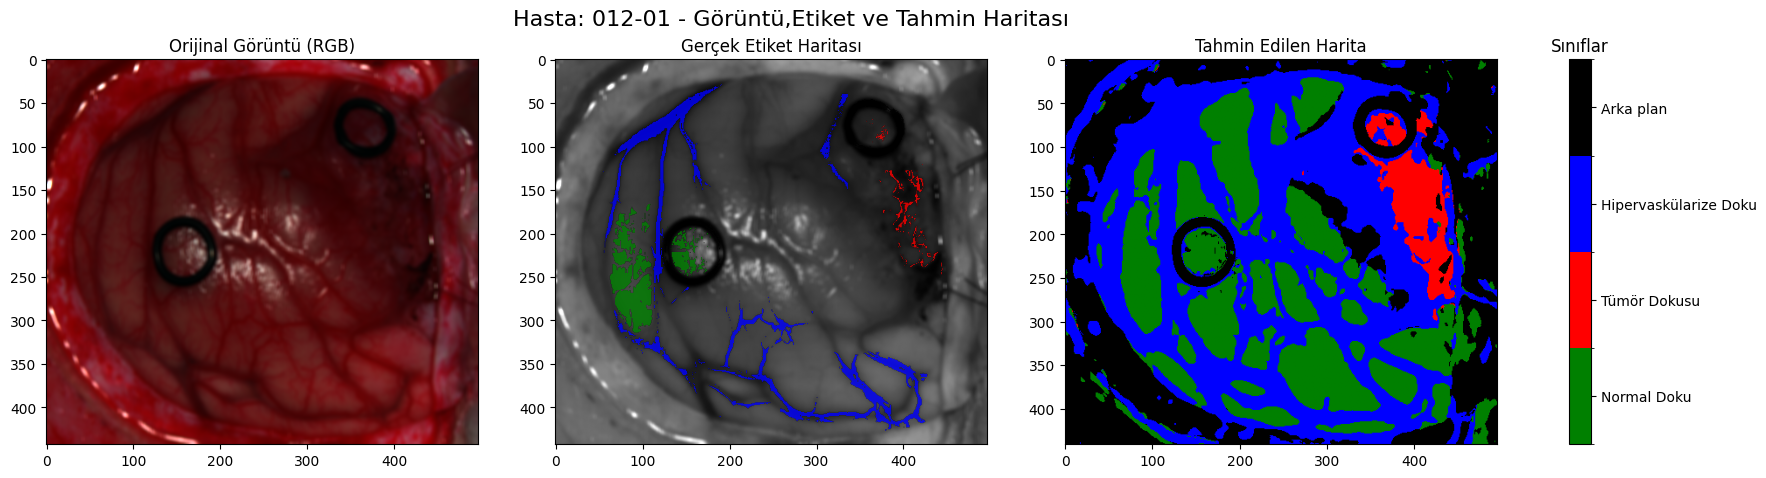

In [12]:
#Belirtilen tek hasta klasorunu, image,model,batch degeri vererek dogrulama

hasta='012-01'
modelno=2
hasta_sayisi=60
rawfile="calibrated_pca_5"
patch_size=3
epoch=20
batch=16
filters=[noise,normalize]

modelklasor='model'  #İlk hesaplama icin model60, sonraki hesapmala icin model
secimli=False #True ise listeden modeli sec

if (secimli==True):
    # klasordeki modelleri listeler ve icinden birini seçmemizi saglar
    modelfile = list_and_select_h5_files(modelklasor)
else:     
    #modelfile yukarıda secildi ise nurayı kapat
    modelfile=f'{modelklasor}/model{modelno}/model{modelno}_3dcnn_{rawfile}#filtre#_h{hasta_sayisi}_p{patch_size}_ep{epoch}_bat{batch}.h5'


hasta_test(hasta=hasta,
                       hasta_dataset_path=data_folder,
                       rawfile=rawfile,               
                       modelfile=modelfile,               
                       patch_size=patch_size,
                       showimage=False,               
                       fullclasses=True,               
                       filters=filters,
                       filtreuygula=True,
                       epoch=epoch,
                       batch=batch
                      )

### Tek Hasta Toplu Doğrulama Image>Model>Batch

In [ ]:
#Belirtilen birden tek hasta klasorunu, sırası ile belirtilen image,model,batch kombinasyonları ile dogrular

from tensorflow.keras.models import load_model
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable



hasta='012-01'
hasta_sayisi=60
patch_size=3
epoch=20
modelklasor='model'  #İlk hesaplama icin model60, sonraki hesapmala icin model
filters=[noise,normalize]

#image_list = [("calibrated_ort_5","(Her 5 Bantın Ortalaması)"),("calibrated_par_5","(Her 5.Banttaki Resim)"),("calibrated_pca_5","(Her 5 Bantın PCA sı)")] # Döngü ile her bir string üzerinde işlem yapın  "calibrated_ort_5", "calibrated_par_5", 

image_list = [("calibrated_par_5","(Her 5.Bant)")] # Döngü ile her bir string üzerinde işlem yapın  "calibrated_ort_5", "calibrated_par_5", 
batch_list = [64]
model_list = [2]

custom_cmap = ListedColormap(colors)
bounds = [1, 2, 3, 4, 5]  # Sınıf sınırları (5 dahil değil)
norm = BoundaryNorm(bounds, custom_cmap.N)

for rawfile,filecaption in image_list:            
    pngfolder=f'png/{rawfile}'    
    if not os.path.exists(pngfolder):
        os.makedirs(pngfolder)
        
    all_patches, all_labels, islenenfiltreler,hyperspectral_image,gtmap=load_images(hasta_dataset_path=data_folder+"/"+hasta,
                                                          rawfile=rawfile,
                                                          patch_size=patch_size,
                                                          usedirectfile=True,
                                                          showimage=False,
                                                          fullclasses=True,
                                                          filters=filters,
                                                          filtreuygula=True,
                                                          hasta_sayisi=1
                                                         )  
    print("shape", hyperspectral_image.shape[2])
    patch_data = all_patches[0].reshape(-1, patch_size, patch_size, hyperspectral_image.shape[2], 1)  # (N, patch_size, patch_size, bands, 1)

    hyperspectral_image=adjust_auto_brightness(hyperspectral_image)              
    
    # 2 satır ve 6 sütunlu grid (son sütun colorbar için ayrılmış)
    fig, axs = plt.subplots(len(model_list)+1, 5, figsize=(20, 8*len(model_list)), gridspec_kw={'width_ratios': [1, 1, 1, 1,0.1]})
    plt.suptitle(f"Hasta: {hasta} / {filecaption} Görüntü ve Tahmin Haritası", fontsize=16)

    axs[0, 0].axis("off")
    
    
    # İlk satır: Orijinal görüntü ve gerçek etiket haritası
    axs[0, 1].set_title("Orijinal Görüntü (RGB)", fontsize=12)
    axs[0, 1].imshow(rgb(hyperspectral_image, bolen=10), cmap='gray')
    #axs[0, 0].axis("off")
    
    axs[0, 2].set_title("Gerçek Etiket Haritası", fontsize=12)
    masked_gtmap = np.ma.masked_equal(gtmap, 0)
    axs[0,2].imshow(hyperspectral_image[:, :, 50], cmap='gray')  # Bir bandı görselleştir
    im=axs[0,2].imshow(masked_gtmap, cmap=custom_cmap, norm=norm, alpha=0.8)  # Etiketler    
    
    axs[0, 3].axis("off")

    # Colorbar için ayrı subplot
    fig.colorbar(im, cax=axs[0,4], ticks=[1.5, 2.5, 3.5, 4.5])
    axs[0,4].set_yticklabels([CLASS_NAMES[i] for i in range(1, 5)], fontsize=10)
    axs[0,4].set_title("Sınıflar", fontsize=12)
    axs[0,4].tick_params(axis="y", labelsize=10)    
        
    
    # Geri kalan sütunları boş bırak (ilk satır)
    #for col in range(2, 4):
    #    axs[0, col].axis("off")
    
    for modelno in model_list:
        # Görselleştirme
        #fig, axs = plt.subplots(1, 5, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.05]})        

        kolon=0;
        for batch in batch_list:
            modelfile=f'{modelklasor}/model{modelno}/model{modelno}_3dcnn_{rawfile}#filtre#_h{hasta_sayisi}_p{patch_size}_ep{epoch}_bat{batch}.h5'            
            modelfile=modelfile.replace('#filtre#',islenenfiltreler)
            print(f'model file  {modelfile}')
            # Modeli yükle
            model = load_model(modelfile)
            
            predictions = model.predict(patch_data)  # (N, num_classes)    
            # Tahmin edilen sınıfı belirleyin
            predicted_classes = np.argmax(predictions, axis=1)  # (N,)

            height, width = hyperspectral_image.shape[:2]
            class_map = predicted_classes.reshape(height-2, width-2)        
            masked_label_map = np.ma.masked_equal(gtmap, 0)             
            
            # Orijinal görüntü
            axs[modelno, kolon].set_title(f'Batch {batch}', fontsize=12)
            im=axs[modelno, kolon].imshow(class_map, cmap=custom_cmap, norm=norm)
            
            kolon+=1


        axs[modelno, 4].text(
        0.5, 0.5,
        f"{hasta}",
        fontsize=16,
        color="blue",
        rotation=90,
        ha='center',
        va='center',
        transform=axs[modelno, 4].transAxes
        )
        
        axs[modelno, 4].axis("off")
        """
        # Colorbar için ayrı subplot
        fig.colorbar(im, cax=axs[1,4], ticks=[1.5, 2.5, 3.5, 4.5])
        axs[1,4].set_yticklabels([CLASS_NAMES[i] for i in range(1, 5)], fontsize=10)
        axs[1,4].set_title("Sınıflar", fontsize=12)
        axs[1,4].tick_params(axis="y", labelsize=10)    
        """
        
    plt.subplots_adjust(wspace=0.3)    
    plt.tight_layout()
    pngfilename=f'{pngfolder}/{rawfile}_{hasta}{islenenfiltreler}_toplu.png'
    plt.savefig(pngfilename, dpi=100, bbox_inches='tight')
    plt.show()   



### Toplu Hasta Doğrulama Model>Image>Hasta

In [ ]:
#Belirtilen birden fazla hasta klasorlerini, sırası ile belirtilen image,model,batch kombinasyonları ile dogrular

hasta_sayisi=60
patch_size=3
epoch=20
filters=[noise,normalize]
modelklasor='model'  #İlk hesaplama icin model60, sonraki hesapmala icin model


#modelfile=f'model/model{modelno}/model{modelno}_3dcnn_{rawfile}#filtre#_h{hasta_sayisi}_p{patch_size}_ep{epoch}_bat{batch}.h5'
hasta_list =["012-01","015-01","020-01","039-01","039-02","043-01","043-02","035-01","035-02","041-02"]
image_list = ["calibrated_ort_5","calibrated_par_5","calibrated_pca_5"] # Döngü ile her bir string üzerinde işlem yapın  "calibrated_ort_5", "calibrated_par_5", 
model_list = [2]
batch_list = [32,64]

for modelno in model_list:        
    for rawfile in image_list:
        for batch in batch_list:
            modelfile=f'{modelklasor}/model{modelno}/model{modelno}_3dcnn_{rawfile}#filtre#_h{hasta_sayisi}_p{patch_size}_ep{epoch}_bat{batch}.h5'
            print(modelfile)          
                  
            for hastaadi in hasta_list:
                hasta_test(hasta=hastaadi,
                           hasta_dataset_path=data_folder,
                           rawfile=rawfile,               
                           modelfile=modelfile,               
                           patch_size=patch_size,
                           showimage=False,               
                           fullclasses=True,               
                           filters=filters,
                           filtreuygula=True,
                           epoch=epoch,
                           batch=batch
                          )